In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tanlikesmath/the-oxfordiiit-pet-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/tanlikesmath/the-oxfordiiit-pet-dataset/versions/1


In [ ]:
path=path+"/images"

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import plot_model
import tensorflow as tf


Data Preprocessing

In [ ]:
images_path=[]
for image in sorted(os.listdir(path)):               # I just try to sort it as in the folder
    if image.endswith(('.jpg', '.png')):
        images_path.append(os.path.join(path,image))
print(images_path[0])
print(len(images_path))

/root/.cache/kagglehub/datasets/tanlikesmath/the-oxfordiiit-pet-dataset/versions/1/images/Abyssinian_1.jpg
7390


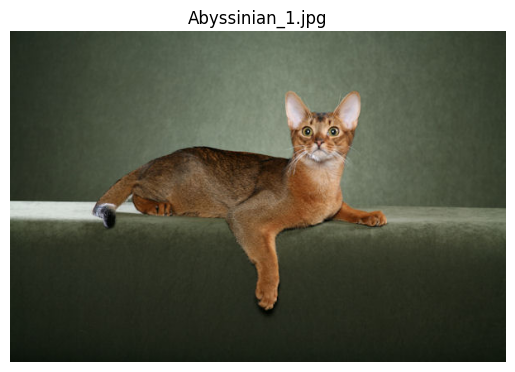

In [ ]:
# trying to plot image 1
image1= images_path[0]
image = Image.open(image1)
plt.imshow(image)
plt.title(sorted(os.listdir(path))[0])
plt.axis("off")
plt.show()


In [ ]:
#2. Split the data into training and testing sets (e.g., 80% training, 20% testing).
train,test=train_test_split(images_path, test_size=0.2, random_state=42)

In [ ]:
# firstly I want to preproces my image and convert it to arrays

def convert_to_array_and_preprocess(image_path,size):
    data = []
    for i in image_path:
            image = Image.open(i).convert('RGB')                 #to make all my data with the same channel as if may be it found greyscale image
            image = image.resize(size)
            image_to_array = np.array(image).astype('float32') / 255.0
            data.append(image_to_array)
    return np.array(data)


X_train=convert_to_array_and_preprocess(train,(128,128))
X_test=convert_to_array_and_preprocess(test,(128,128))
print(X_train.shape)
print(X_test.shape)

(5912, 128, 128, 3)
(1478, 128, 128, 3)


In [ ]:
X_train= np.reshape(X_train, (len(X_train), 128, 128, 3))
X_test= np.reshape(X_test, (len(X_test), 128, 128, 3))

In [ ]:
# 3. Create a noisy version of the dataset by applying a noise function.
noise_factor = 0.5
X_train_noise = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noise = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noise = np.clip(X_train_noise, 0., 1.)
X_test_noise = np.clip(X_test_noise, 0., 1.)

In [ ]:
def show_images(data, number_of_images):
    n = number_of_images
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

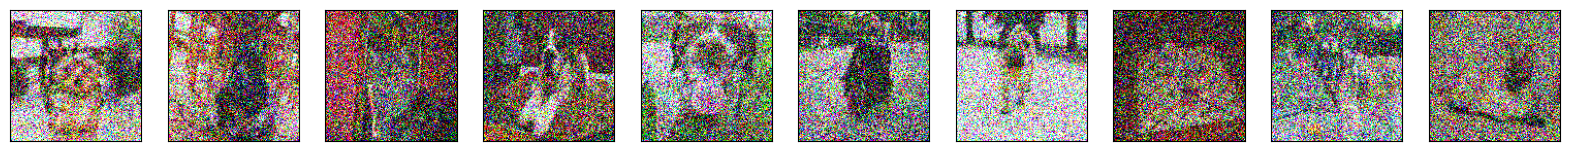

In [ ]:
show_images(X_test_noise,10)

In [ ]:
# 4. Ensure the noisy dataset has the same shape as the original.
print(X_train_noise.shape)
print(X_test_noise.shape)

(5912, 128, 128, 3)
(1478, 128, 128, 3)


CNN Architecture

In [ ]:
# Encoder
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K,callbacks
input_img = Input(shape=(128,128,3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)
# Decoder

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,507 (115.26 KB)

 Trainable params: 29,507 (115.26 KB)

 Non-trainable params: 0 (0.00 B)

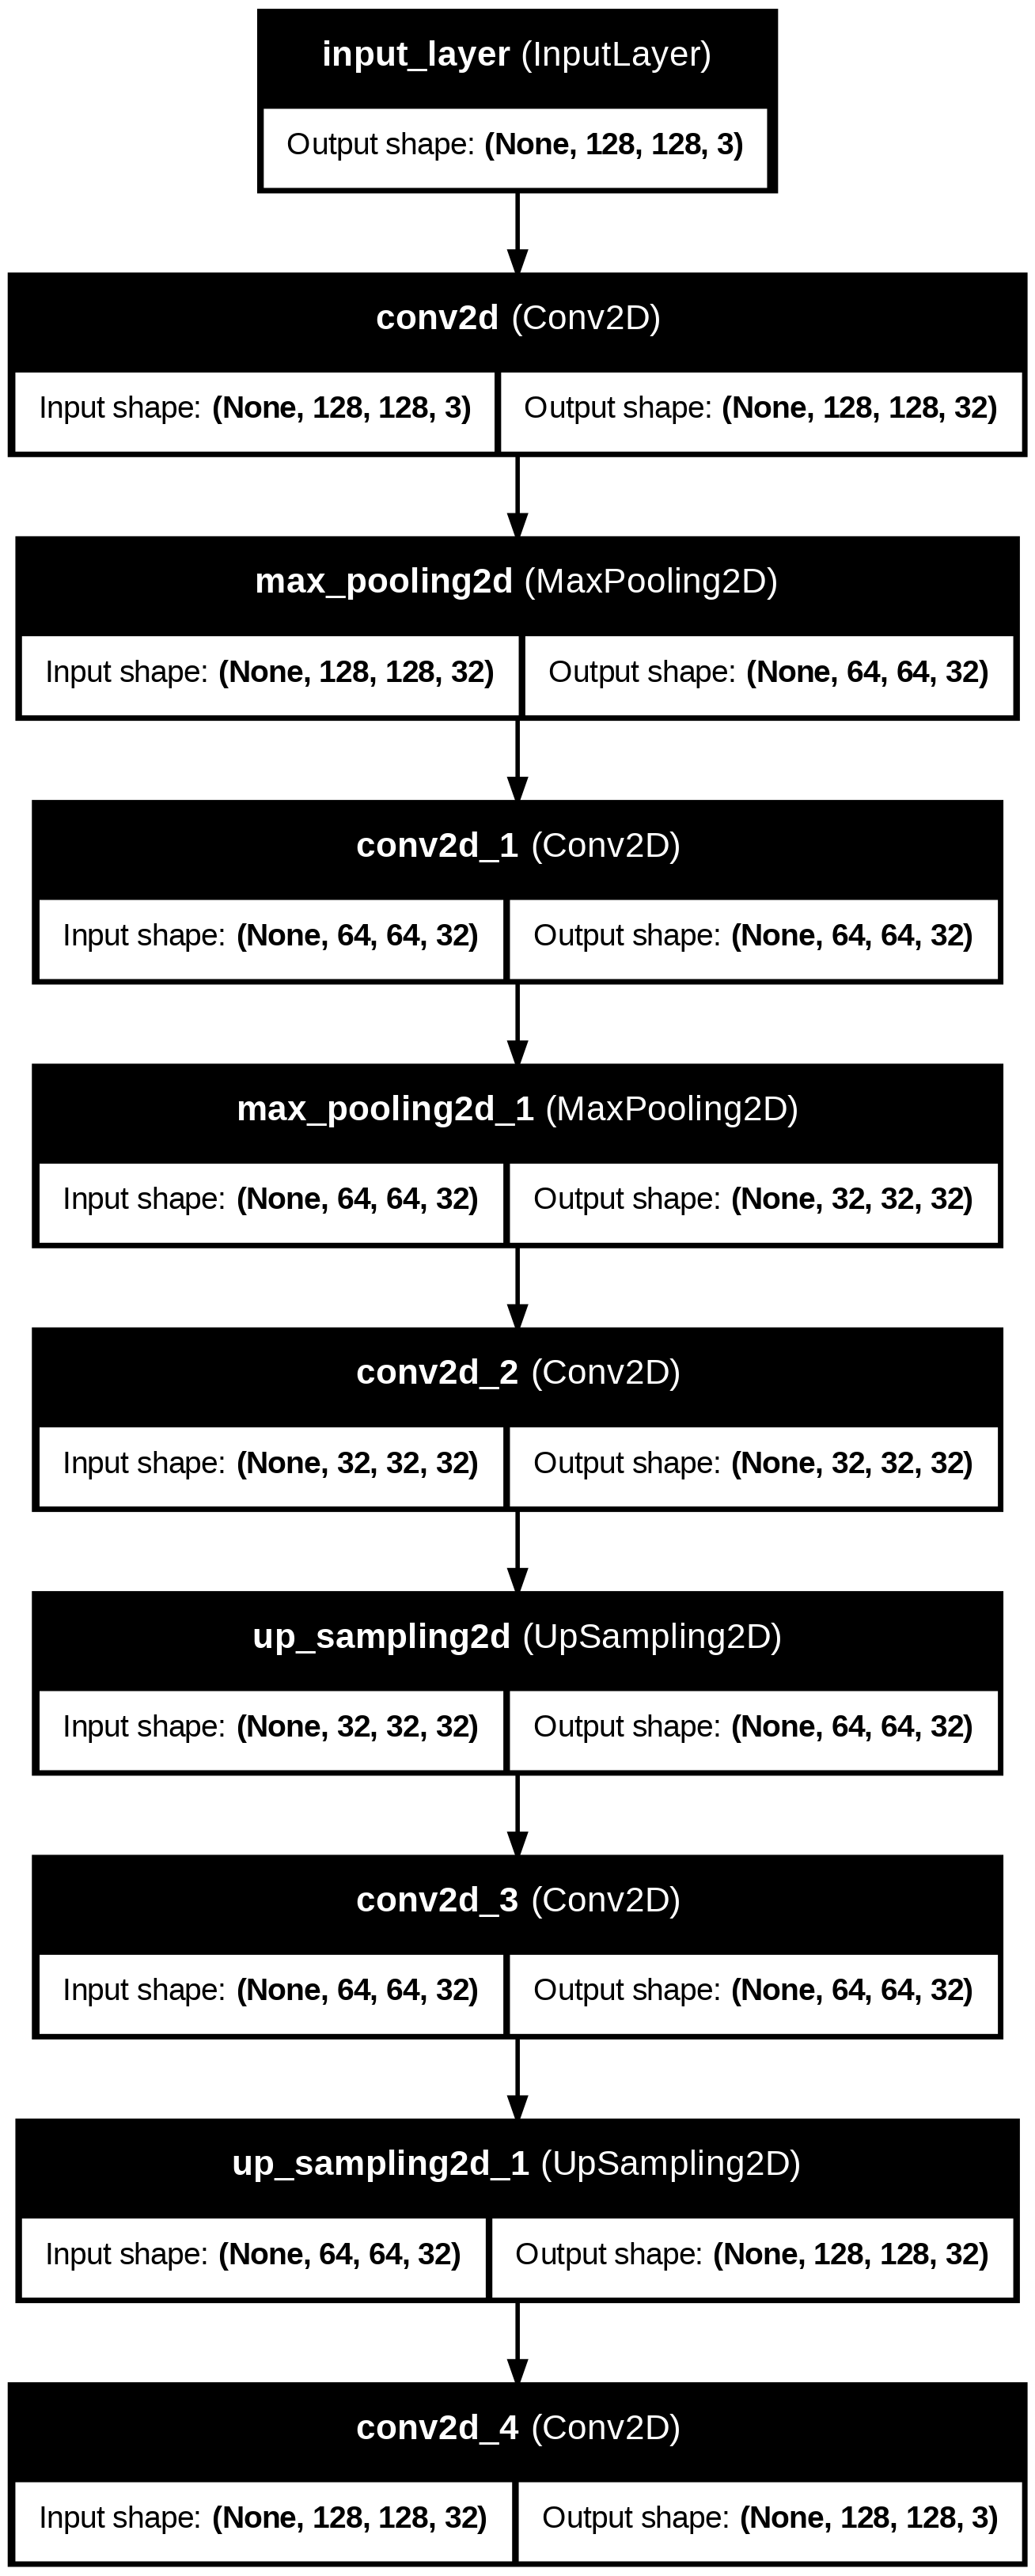

In [ ]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
callback =callbacks.EarlyStopping(monitor='loss',
                                              patience=3)

In [ ]:
history_ = model.fit(X_train_noise, X_train,epochs=100,batch_size=128,shuffle=True,validation_data=(X_test_noise, X_test),callbacks=[callback])

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 308ms/step - loss: 0.0473 - val_loss: 0.0142
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0126 - val_loss: 0.0100
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.0101 - val_loss: 0.0093
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━

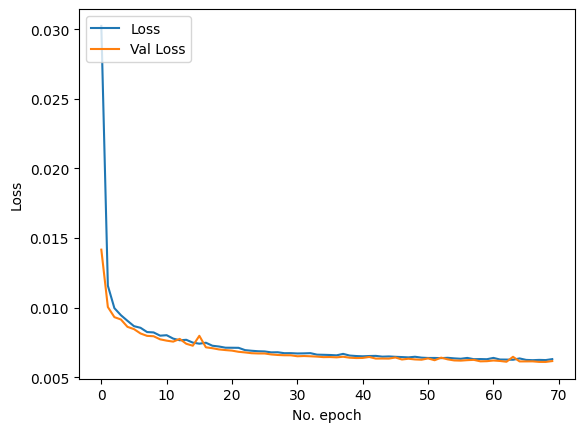

In [ ]:
plt.plot(history_.history['loss'], label='Loss')
plt.plot(history_.history['val_loss'], label='Val Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
decoded_imgs = model.predict(X_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


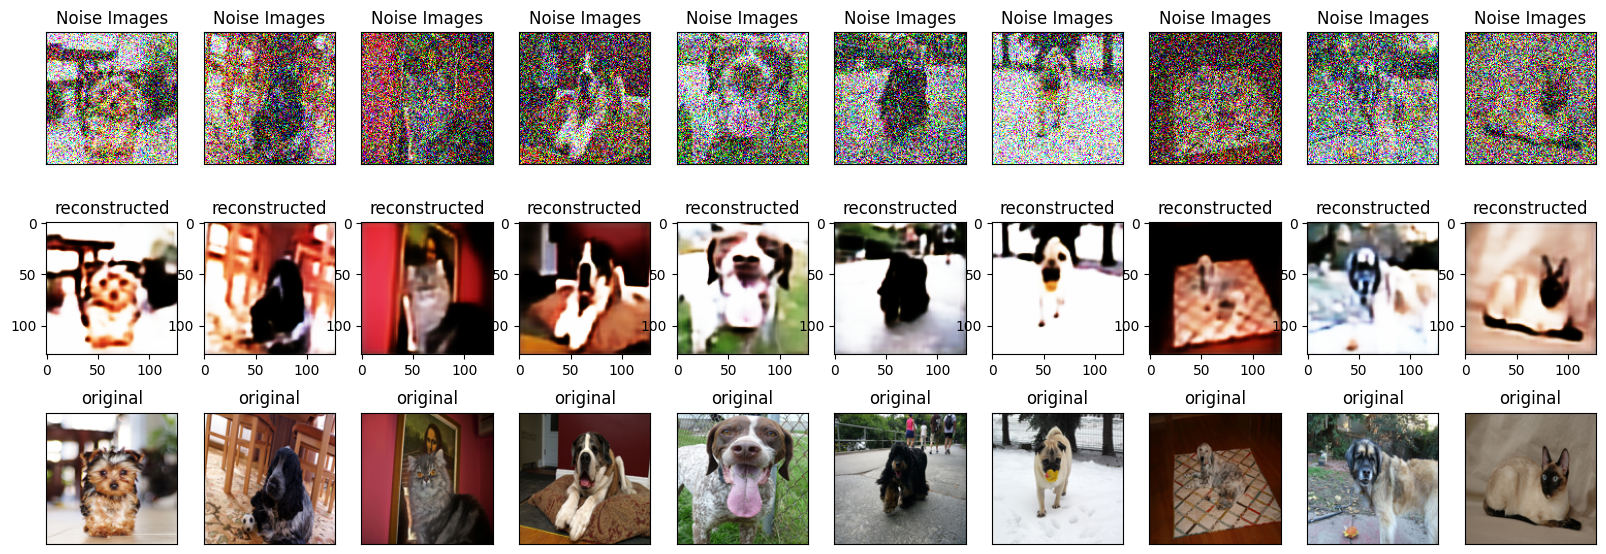

In [ ]:
n = 10
plt.figure(figsize=(20, 7))
for i in range(n):
  bx = plt.subplot(3, n, i + 1)
  plt.title("Noise Images")
  plt.imshow(tf.squeeze(X_test_noise[i]))
  bx.get_xaxis().set_visible(False)
  bx.get_yaxis().set_visible(False)

  cx = plt.subplot(3, n, i + n + 1)
  plt.title("reconstructed")
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  bx.get_xaxis().set_visible(False)
  bx.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i + 2*n + 1)
  plt.title("original")
  plt.imshow(tf.squeeze(X_test[i]))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()